In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import importlib

import kaggle_functions as kaggle
import model11_stacking
importlib.reload(kaggle); 
importlib.reload(model11_stacking);
from model11_stacking import Model, model_number

### Create datasets

In [2]:
complete_dataset, train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset(return_complete_set=True)

batch_size = 32
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

In [ ]:
kaggle.show_images(train_dataset.batch(32), 9)

### Train new model

In [ ]:
Model().build(None).summary()

In [3]:
# Fit model
# See {model}.py for specific training instructions, like epochs or valid_patience
model_name = 'Stacking_1'

model, history = kaggle.train_model(
    Model().build(None), train_dataset.batch(32), valid_dataset, 
    epochs=5, valid_patience=5, epoch_length=epoch_length)

Epoch 1/15
298/298 [==============================] - 247s 760ms/step - loss: 2.7838 - accuracy: 0.7625 - val_loss: 2.4848 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 2/15
298/298 [==============================] - 177s 593ms/step - loss: 2.0915 - accuracy: 0.9714 - val_loss: 2.5797 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 3/15
298/298 [==============================] - 192s 644ms/step - loss: 2.0393 - accuracy: 0.9841 - val_loss: 2.6266 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 4/15
298/298 [==============================] - 179s 602ms/step - loss: 2.0198 - accuracy: 0.9872 - val_loss: 2.6652 - val_accuracy: 0.8789 - lr: 1.0000e-04
Epoch 5/15
298/298 [==============================] - ETA: 0s - loss: 2.0083 - accuracy: 0.9891

INFO:tensorflow:Assets written to: models/model11/Stacking_1\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


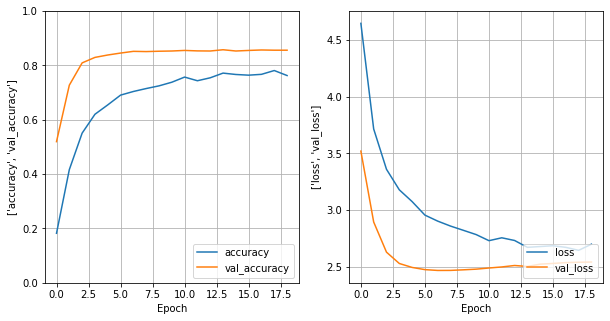

In [12]:
# Save model
model.save(f'models/{model_number}/{model_name}')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

In [3]:
model = keras.models.load_model(f'models/{model_number}/WideResNet_2_73')

### Fine-tune

In [30]:
# Fine-tune model
fine_model, history = kaggle.fine_tune_model(
    model,
    complete_dataset.batch(32).cache(), valid_dataset, 
    epochs=1, learning_rate=1E-5)

C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


372/372 [==============================] - 235s 611ms/step - loss: 2.3633 - accuracy: 0.8853 - val_loss: 2.4720 - val_accuracy: 0.8667


In [14]:
# Save fine-tuned model
fine_model_name = 'Stacking_2'
fine_model.save(f'models/{model_number}/{fine_model_name}')

INFO:tensorflow:Assets written to: models/model11/Stacking_2\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Evaluate

In [ ]:
model_name = ''
model = keras.models.load_model(f'models/{model_number}/{model_name}')
test_pred = np.argmax(model.predict(valid_dataset), axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)

### Generate test predictions

In [6]:
model_name = 'WideResNet_8_83'
kaggle.generate_test_pred_filepath(f'models/model10/{model_name}')

Model found, generating predictions...


In [ ]:
kaggle.generate_test_pred(fine_model, f'models/{model_number}/{model_name}_test_pred.csv')

### Hypertune models

In [15]:
importlib.reload(model11_stacking);
from model11_stacking import Model, model_number

tuner = kaggle.hypertune_model(
    Model(), train_dataset_augmented, valid_dataset, 
    model_number, 'hypertuner2021-12-07', trials=4, 
    epochs=30, valid_patience=5, epoch_length=epoch_length)

Trial 4 Complete [01h 15m 22s]
val_accuracy: 0.8566021919250488

Best val_accuracy So Far: 0.86417156457901
Total elapsed time: 04h 40m 07s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in models/model11\hypertuner2021-12-07
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
l2_reg: 1e-05
Score: 0.86417156457901
Trial summary
Hyperparameters:
dropout: 0.2
l2_reg: 1e-05
Score: 0.8566021919250488
Trial summary
Hyperparameters:
dropout: 0.2
l2_reg: 0.0001
Score: 0.8519764542579651
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
l2_reg: 0.0001
Score: 0.8519764542579651


In [ ]:
tuner = kaggle.load_hypertuner(Model(), model_number, 'hypertuner2021-12-03')

In [23]:
model = tuner.get_best_models(1)[0]